# Classification Models to Identify Water Pump Functionality in Tanzania

# Overview

This project consists of classification models to identify water pump functionality in Tanzania. Limited access to safe water is a major health risk. These models are potential tools for government agencies or non-governmental organizations to identify areas with limited access to clean water. Through an iterative modeling process, we produced a model that predicted pump functionality with 85% accuracy. By identifying non-functional water pumps, organizations can divert resources to areas in need of assistance and improve water access and health in Tanzania.

# Business Understanding

Millions of people in Tanzania lack access to safe water. This results in paying high prices for water from vendors or collecting water from unsafe natural sources. In order to combat this problem, resources must be allocated to fix non-functioning water distribution points.
Age is an important metric in predicting the condition of distribution points. Older pumps and engine systems are more likely to fail than newer ones. In many cases age related data is not available.
The goal of this analysis is to build the model that can predict the condition of waterpoints based on their other features such as regional factors, installer, type of pump, population and others.

# Data Understanding

Our data consists of 57,588 entries containing information on water pumps in Tanzania. The data was collected by Taarifa and the Tanzanian Ministry of Water. The dataset contains a number of variables about each pump, including regional information, when and how it was installed, payment information, what type of pump is operating, etc. Our target variable is 'status_group', a categorization of the pump's functionality status. Each pump has been classified as 'functional', 'functional needs repair', or 'non functional'. 

The data cleaning and exploration was performed in a separate Jupyter Notebook. Our data cleaning process can be found in 'main_notebook_cleaning' within this project's repository. 

### Imports

In [1]:
#import statements
import pandas as pd
import numpy as np

#data visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#sci-kit learn
import sklearn
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_confusion_matrix, confusion_matrix
from sklearn.dummy import DummyClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Modeling

We used a variety of scikit-learn classification models to see which model produced the best results for the classification of functional vs non-functional water pumps.

Our data was imported from the 'water_well_train_clean.csv' file. This file contains the dataset after cleaning in our project's EDA notebook. However, saving the cleaned dataframe to a csv resulted in some column datatypes being automatically changed. Before we could work with the data, we had to change the values in 'region_code' and 'district_code' from integers to strings.

In [2]:
#Read in cleaned data
df = pd.read_csv('./data/water_well_train_clean.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57588 entries, 0 to 59399
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     57588 non-null  int64  
 1   amount_tsh             57588 non-null  float64
 2   date_recorded          57588 non-null  object 
 3   funder                 57588 non-null  object 
 4   gps_height             57588 non-null  int64  
 5   installer              57588 non-null  object 
 6   longitude              57588 non-null  float64
 7   latitude               57588 non-null  float64
 8   wpt_name               57588 non-null  object 
 9   num_private            57588 non-null  int64  
 10  basin                  57588 non-null  object 
 11  subvillage             57588 non-null  object 
 12  region                 57588 non-null  object 
 13  region_code            57588 non-null  int64  
 14  district_code          57588 non-null  int64  
 15  lg

In [4]:
#change data types for 'region_code' and 'district_code' from int to str
df['region_code'] = df['region_code'].astype(str)
df['district_code'] = df['district_code'].astype(str)

Our goal in modeling was to create a classification model with the highest accuracy in classifying functional and non-functional water pumps. The dataset's target column 'status_group' contains a third value 'functional needs repair'. For our analysis, we grouped 'functional needs repair' with 'functional'. In doing so, we trained our model with the focus of identifying 'non functional' water pumps. These non-functional pumps represent areas that require the most maintenance in pump infrastructure. Any organization addressing access to water needs to prioritize its resources and understand where to send personnel and materials. Our model could be used to identify nonfunctional pumps based on features captured in the dataset and highlight populations with the greatest need, allowing aid organizations to alleviate the water burden for those people.

In [5]:
#SETTING UP BINARY CLASSIFICATION TARGET
df_binary = df.copy()

#group 'functional needs repair' with 'functional'
df_binary['status_group'] = df_binary['status_group'].str.replace('functional needs repair','functional')
df_binary['status_group'].value_counts()

functional        35320
non functional    22268
Name: status_group, dtype: int64

In [6]:
X = df_binary.drop('status_group', axis=1)

In [7]:
y = df_binary['status_group']

In [8]:
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

The data was split into a training set and a test set. The models were trained and fit to the train data. Model performances were judged using the test data to see how the models perform on unseen data.

### Dummy Classifier

The dummy classifier set the baseline for our model metrics. Here, the dummy classifier predicts the most frequent class everytime. For our training data, the most frequent class is 'functional' with 61% frequency.

In [9]:
#dummy classifier baseline picks the most frequent class
dummy_clf = DummyClassifier(strategy='most_frequent')

In [10]:
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [11]:
dummy_clf.score(X_train, y_train)

0.6121877242944131

The dummy classifier has a baseline accuracy of 0.61, predicting the correct class 61% of the time on the training data.

### Pipeline Setup

The function below helped us streamline our feature selection process and simplified our workflow in conjunction with pipelines. It takes in a dataframe and a list of features and categorizes the features into numerical, categorical, and boolean groups. 

With this function, we were able to pass in a list of desired features and our X dataframe and have our pipeline act only on the features given.

In [9]:
#helper function to categorize list of features by datatype
#create col lists of numeric, categorical, and boolean data
#return column lists in as tuple (numerical, categorical, boolean)
def GrabTypes(features, df):
    df_features = df[features]
    num_df = df_features.select_dtypes(include='number')
    num_cols = list(num_df.columns)
    cat_df = df_features.select_dtypes(include='object')
    cat_cols = list(cat_df.columns)
    bool_df = df_features.select_dtypes(include='boolean')
    bool_cols = list(bool_df.columns)
    return (num_cols, cat_cols, bool_cols)

We chose 17 columns to include in our first model. The columns were picked to capture as much complexity as possible. In cases where multiple columns captured the same information (e.g. 'extraction_type', 'extraction_type_group', and 'extraction_type_class'), the most granular feature was selected for the model. 

In [10]:
picked_features = ['amount_tsh', 'installer',  'gps_height', 'basin', 'region', 
                   'district_code', 'lga', 'population', 'public_meeting', 
                   'management', 'permit', 'extraction_type', 'payment', 
                   'water_quality', 'quantity', 'source', 'waterpoint_type']

features_type = GrabTypes(picked_features, df)
features_type

(['amount_tsh', 'gps_height', 'population'],
 ['installer',
  'basin',
  'region',
  'district_code',
  'lga',
  'management',
  'extraction_type',
  'payment',
  'water_quality',
  'quantity',
  'source',
  'waterpoint_type'],
 ['public_meeting', 'permit'])

Our iterative modeling process used scikit-learn's Pipeline to streamline transformations and GridSearching. Within the pipeline, there are 3 subpipelines in order to process the three types of features: numerical features, categorical features, and boolean features.

Numerical features were transformed with StandardScaler. Categorical features were transformed with OneHotEncoder. The handle_unknown parameter for OneHotEncoder is set to 'ignore'. Any unknown categories encountered during transformation would have their resulted encoded columns as all zzeros. Finally, boolean features were transfomed with OrdinalEncoder.

In [11]:
#create subpipes for numeric and categorical features
#StandardScaler on numerical features
subpipe_num = Pipeline(steps=[('ss', StandardScaler() )])

#OHE categorical features, handle_unknown = ignore
subpipe_cat = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore') )])

#boolean pipeline with ordinal encoder
subpipe_bool = Pipeline(steps=[('ord', OrdinalEncoder() )])

ColumnTransformer contained our three subpipelines. The parameter remainder = 'drop' meant any columns that were not specified to a subpipeline to be dropped from the transfomers and model estimator.

In [12]:
#column transformer with 3 subpipes
CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, features_type[0]),
                                     ('subpipe_cat', subpipe_cat, features_type[1]),
                                     ('subpipe_bool', subpipe_bool, features_type[2])],
                       remainder='drop')

With our subpipes and ColumnTransformer set up, we can now build models using a pipeline.

## First Model - Random Forest Classifier

A Random Forest Classifier fits a number of decision trees on subsets of the data, using the average to improve the prodictive accuracy and reduce overfitting. 

In [16]:
#Instatiate a RandomForestClassifier with random_state = 42 and default hyperparameters
rfc = RandomForestClassifier(random_state=42)

#Create pipline with transformer 'ct' and estimator 'rfc'
first_rfc_pipe = Pipeline(steps = [('ct', CT),
                                   ('rfc', rfc )])

In [17]:
first_rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'population']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['installer', 'basin',
                                                   'region', 'district_code',
                                                   'lga', 'management',
                                      

In [18]:
first_rfc_pipe.score(X_train, y_train)

0.9646917181820287

A high accuracy of 96% for our first model on the train data was an immediate flag that there was overfitting.

We used GridSearchCV to optimize hyperparameters. The goal of GridSearchCV is to improve model performance by constructing models with different hyperparameter values to find the values that resulted in the best performing model. The mean cross validated scores from GridSearchCV were compared to the train accuracy score to assess overfitting. 

In [19]:
params = {'rfc__n_estimators':[100, 200],
          'rfc__max_depth':[None, 50],
          'rfc__min_samples_leaf': [1, 10],
          'rfc__min_samples_split': [2, 5, 10]}

gs = GridSearchCV(estimator = first_rfc_pipe, param_grid = params, cv=5)

In [29]:
#GridSearchCV fits will be commented out in this notebook to avoid excessive runtime
#gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'population']),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                            

In [30]:
gs.best_params_

{'rfc__max_depth': 50,
 'rfc__min_samples_leaf': 1,
 'rfc__min_samples_split': 10,
 'rfc__n_estimators': 200}

Out of these four hyperparameters, n_estimators, max_depth, and min_samples_split used values different from the default hyperparameters for RandomForestClassifier.

In [34]:
gs.best_score_

0.8450834843555428

Our cross validated accuracy score for this RandomForestClassifier model is 0.845. 

In [20]:
#saving best GridSearch params as a model within pipeline
rfc = RandomForestClassifier(n_estimators=200, max_depth=50, min_samples_leaf=1, 
                             min_samples_split=10, random_state=42)
first_rfc_pipe = Pipeline(steps = [('ct', CT),
                                   ('rfc', rfc )])

In [21]:
first_rfc_pipe.fit(X_train, y_train)
first_rfc_pipe.score(X_train, y_train)

0.9052348868977333

By adjusting RandomForestClassifier hyperparameters, we were able to reduce overfitting. The accuracy of the model dropped to 90.5%, indicating it is fitting worse on the training set. However, our highest mean cross validation score of 0.845 indicates that the model performs reasonably well on unseen data, predicting the correct class 84.5% of the time. Our final evaluation of this RandomForestClassifier model will occur later with the holdout validation test set.

#### Feature Importances

We've written a function to help connect feature importances of our models to the associated features transformed within the pipeline.

In [13]:
#helper function to map feature importances into a dictionary
#takes in a pipeline and digs into the ColumnTransformer to pull out feature names
#creates a dictionary with feature names as keys and feature importances as values

def dict_feature_importances(pipeline):
    num_names = pipeline.named_steps['ct'].transformers_[0][2]
    ohe_names = pipeline.named_steps['ct'].transformers_[1][1].named_steps['ohe'].get_feature_names()
    bool_names = pipeline.named_steps['ct'].transformers_[2][2]
    all_names = np.concatenate( (num_names, ohe_names, bool_names) )
    
    model_name = list(pipeline.named_steps.keys())[1]
    feature_importances = {name:score for name, score in zip(all_names, pipeline.named_steps[model_name].feature_importances_)}
    return feature_importances


In [ ]:
#call dict_feature_imporatnces pipeline for the first model
rfc_importances_dict = dict_feature_importances(first_rfc_pipe)
rfc_importances_dict

In [15]:
#function to return top n feature importances
#returns a list of tuples with the feature and its associated feature importance
#list is sorted in descending order by feature importance
def top_importance(importances, n):
    #sort feature importance values from the dictionary to pull out top n
    top_features = sorted(importances, key=importances.get, reverse=True)[:n]
    feature_and_importance = [(x, importances[x]) for x in top_features]
    return feature_and_importance

In [25]:
forest_importances = top_importance(rfc_importances_dict, 10)
forest_importances

[('x9_dry', 0.11496753876120527),
 ('gps_height', 0.06947020515438888),
 ('population', 0.0449283169044532),
 ('x9_enough', 0.04351227860557871),
 ('x11_other', 0.04270195733635547),
 ('x6_other', 0.03756829165590128),
 ('amount_tsh', 0.03213112163626943),
 ('x9_insufficient', 0.01901771506429383),
 ('x11_communal standpipe', 0.01886192774061734),
 ('x7_never pay', 0.01733008350984482)]

Feature importance, also known as Gini importance, represents the total reduction of criterion by that feature.This provided a sense of which features were most impactful in the model's branching decisions.

From the list of top 10 feature importances, we saw many OneHotEncoded features from the following columns: 'extraction_type', 'payment', 'quantity', and 'waterpoint_type'. The numerical columns 'gps_height', 'population', and 'amount_tsh' were also in the top feature importances. 

While these features had the greatest importance, this model was trained using a wide range of features which all contributed some complexity to the model.

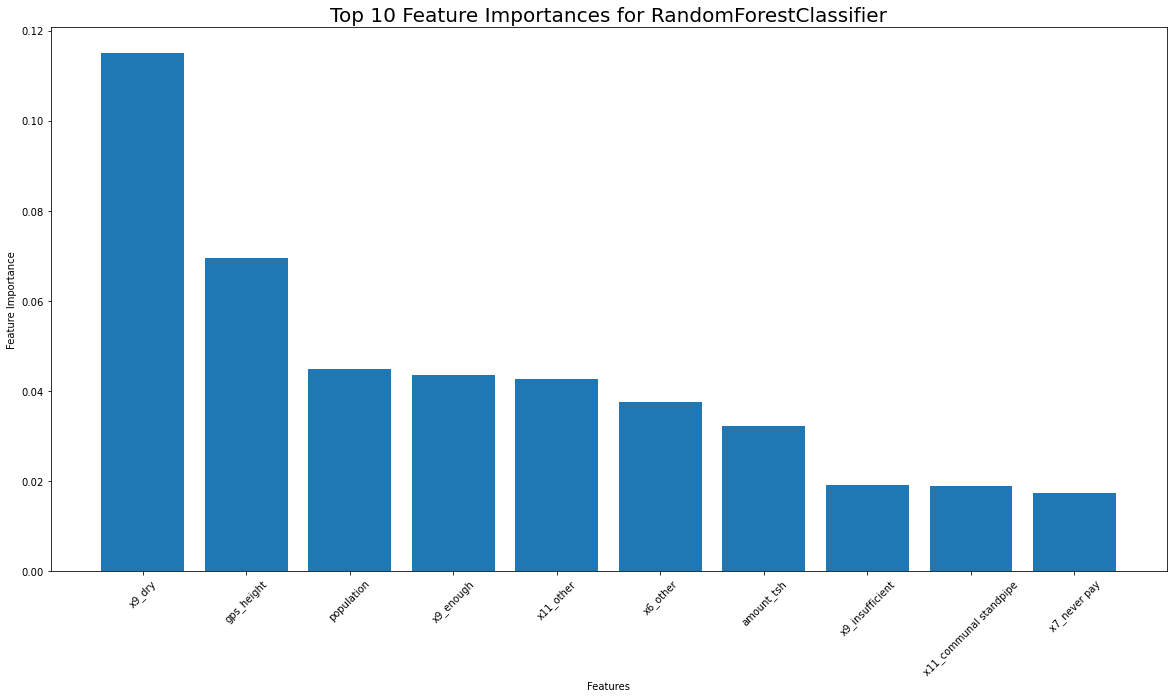

In [107]:
#visualizing feature importance values
fig, ax = plt.subplots(figsize=(20,10))

features = [x[0] for x in forest_importances]
importances = [x[1] for x in forest_importances]
ax.bar(features, importances)

ax.tick_params(axis='x', labelrotation = 45)
ax.set_title('Top 10 Feature Importances for RandomForestClassifier', fontsize=20)
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Features');

fig.savefig('rfc_importances.png', dpi=300)

## Second Model - Bagging Classifier

Our second model was a BaggingClassifier. This BaggingClassifier was an ensemble estimator with a DecisionTreeClassifier as the base estimator. The model bags the original dataset into random subsets, fits the base classifier on these subsets, and aggregates their individual predictions to form a final prediciton.

In [16]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=50, min_samples_leaf=1,min_samples_split=10)

bagging_dt_model = BaggingClassifier(base_estimator=dt, n_estimators=100, random_state=42)

bag_dt_pipe = Pipeline(steps = [('ct', CT),
                                ('baglogreg', bagging_dt_model )])

In [57]:
cross_val_score(bag_dt_pipe, X_train, y_train).mean()

0.8414716657910286

In [59]:
#dtc_gs = GridSearchCV(bag_dt_pipe, dtc_params, cv=5, verbose=1, n_jobs=-2)


#dtc_gs.fit(X_train, y_train)

#dtc_best = dtc_gs.best_estimator_
#dtc_gs.best_params_

In [60]:
#Results from BaggingClassifier grid search

#{'baglogreg__base_estimator': DecisionTreeClassifier(max_depth=50, min_samples_split=10),
 #'baglogreg__max_features': 0.7,
 #'baglogreg__max_samples': 1.0,
 #'baglogreg__n_estimators': 100}
    
#dtc_gs.best_score_
#0.8514029180695847

The GridSearchCV best score for the BaggingClassifier was 0.851, a slight improvement on our RandomForestClassifier's score. 

In [17]:
dt = DecisionTreeClassifier(max_depth=50, min_samples_split=10)

bagging_dt_model = BaggingClassifier(base_estimator=dt, n_estimators=100,
                                     max_features=0.7, max_samples=1.0,
                                     random_state=42)

bag_dt_pipe = Pipeline(steps = [('ct', CT),
                                ('baglogreg', bagging_dt_model )])

In [18]:
bag_dt_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'population']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['installer', 'basin',
                                                   'region', 'district_code',
                                                   'lga', 'management',
                                      

In [30]:
bag_dt_pipe.score(X_train, y_train)

0.9248917598573777

We found the feature importances from the BaggingClassifier as the mean of feature importances for each tree.

In [55]:
bag_importances = np.mean([
    tree.feature_importances_ for tree in bag_dt_pipe.named_steps['baglogreg'].estimators_
], axis=0)
bag_importances

array([0.00037713, 0.00029562, 0.0006311 , ..., 0.00048631, 0.00039695,
       0.00054091])

In [56]:
num_names = bag_dt_pipe.named_steps['ct'].transformers_[0][2]
ohe_names = bag_dt_pipe.named_steps['ct'].transformers_[1][1].named_steps['ohe'].get_feature_names()
bool_names = bag_dt_pipe.named_steps['ct'].transformers_[2][2]
all_names = np.concatenate( (num_names, ohe_names, bool_names) )

In [ ]:
feature_importances = {name:score for name, score in zip(all_names, bag_importances)}
feature_importances

In [58]:
bagging_importances = top_importance(feature_importances, 10)
bagging_importances

[('x0_RC MISSION', 0.004923219779730823),
 ('x0_NYAKILANGANI CO', 0.00478682605501646),
 ('x0_Paffec', 0.003944020006983322),
 ('x0_Communit', 0.003744824240588701),
 ('x0_CONS', 0.0037281923621852505),
 ('x0_KMT', 0.0037052385048023766),
 ('x0_Seram', 0.0036631421291768522),
 ('x0_MI', 0.0035451967887158192),
 ('x0_MSIKIT', 0.003496483616593985),
 ('x0_Milenia', 0.0034747473048666296)]

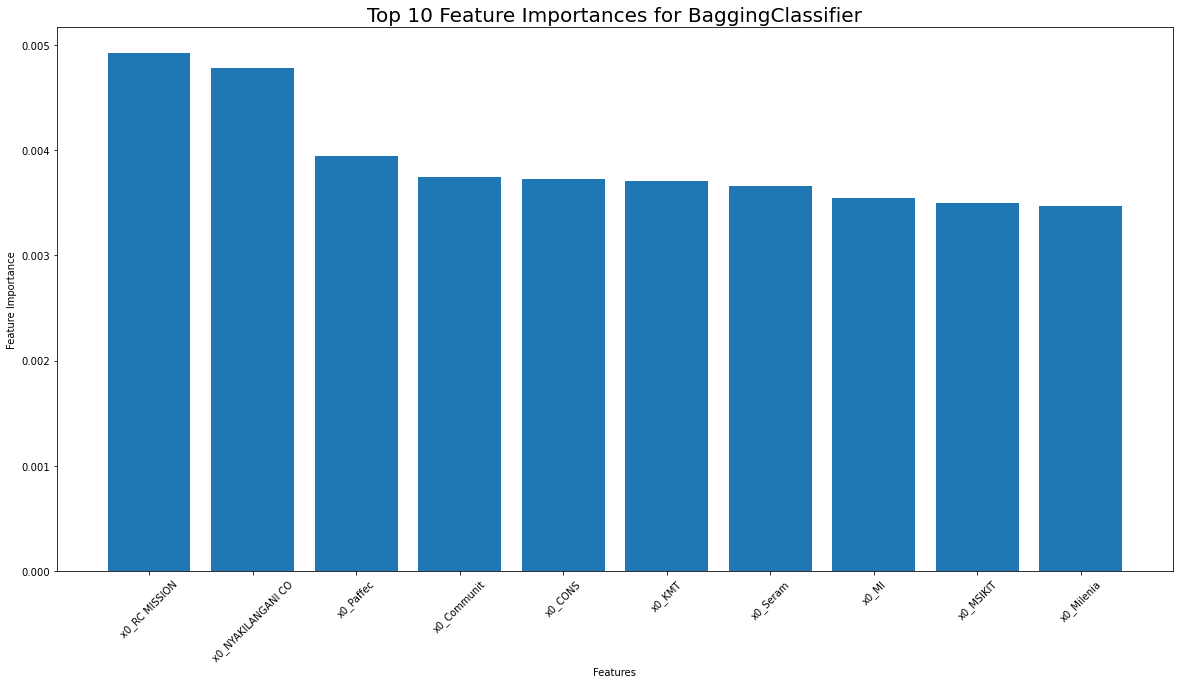

In [111]:
#visualizing feature importance values
fig, ax = plt.subplots(figsize=(20,10))

features = [x[0] for x in bagging_importances]
importances = [x[1] for x in bagging_importances]
ax.bar(features, importances)

ax.tick_params(axis='x', labelrotation = 45)
ax.set_title('Top 10 Feature Importances for BaggingClassifier', fontsize=20)
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Features');

#fig.savefig('bagging_importances.png', dpi=300)

The top feature importances for the Bagging classifier were all OneHotEncoded features from the 'installer' column. This suggests the 'installer' feature is important to the Bagging classifier's splitting decisions.

The accuracy on the train data and the cross valiation scores for this Bagging classifier were both greater than those of the Random Forest. However, we're interested in how the model performs on unseen data: our holdout validation set from the train-test split.

## Third Model - KNN Classifier

Our final model type was a KNeighborsClassifier. The model classifies a data point by searching for the k-nearest neighbors and checking their classifications. The class of the data point is determined by a vote of their neighbors; however, the 'weights' parameter in the classifer can be used to specify how this vote is carried out. In our model, the 'weights' parameter was set to 'distance', meaning points that were close to the query point had a greater influence on the vote than neighbors who were further away.

In [31]:
#pipeline for a knn classifier model
knn = KNeighborsClassifier(n_neighbors=12, leaf_size=2, metric='manhattan', p=2, weights='distance')

knn_model_pipe = Pipeline(steps = [('ct', CT),
                                   ('KN', knn )])


In [ ]:
knn_model_pipe.fit(X_train, y_train)

In [69]:
#grid search for KNN
#grid = {'KN__n_neighbors':range(6, 10), 'KN__leaf_size':range(4), 'KN__metric':['minkowski', 'manhattan'], 'KN__weights':['uniform', 'distance'], 'KN__p':[2]}

#knn_gs = GridSearchCV(estimator=knn_model_pipe, param_grid=grid, cv=5, n_jobs=-1, verbose=3)
#knn_gs.fit(X_train, y_train)

In [70]:
#Results from KNN grid search

#knn_gs.best_params_
#{'KN__leaf_size': 1,
# 'KN__metric': 'manhattan',
# 'KN__n_neighbors': 9,
# 'KN__p': 2,
# 'KN__weights': 'distance'}

#knn_gs.best_score_
#0.829023569023569

#knn_gs.best_estimator_.score(X_test, y_test)

The grid search with cross validation for the KNN model yielded a score of 0.829. This accuracy is lower than those of our other two models.

In [32]:
#saving best GridSearch params as a model within pipeline
knn = KNeighborsClassifier(n_neighbors=9, leaf_size=1, metric='manhattan', 
                           p=2, weights='distance')

knn_model_pipe = Pipeline(steps = [('ct', CT),
                                   ('KN', knn )])

In [33]:
knn_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'population']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['installer', 'basin',
                                                   'region', 'district_code',
                                                   'lga', 'management',
                                      

In [34]:
knn_model_pipe.score(X_train, y_train)

0.9640897409182468

This KNN model suffered from overfitting. The accuracy was high on the train set (96.4%), but cross-validation scores were lower when compared to our previous two models (82.9%).

KNN is a memory-intensive model since the data needs to be kept in memory in order for distances to be calculated. For the number of features in our models, KNN's computational performance suffered from long runtimes.

## Evaluation of Models on Test Set

With our models tuned, we scored them on the holdout test set to evaluate each model's performance on unseen data.

In [38]:
#function that takes in a dictionary, model, and X / y data
#stores the model score on the X, y set 
#model name as string is the key, score as value
def score_to_dict(model_name, model,score_dict, X, y):
    score = model.score(X, y)
    score_dict[model_name] = [model, score]
    return score_dict

In [67]:
#function that produces a dictionary without the model pipeline object
#key = model name, value = score
def score_only_dict(score_dict):
    scores_only = {x: score_dict[x][1] for x in score_dict}
    return scores_only

In [42]:
#initiliaze score dictioanry
#add RFC score to dict
score_dict = {}
score_dict = score_to_dict('RFC',first_rfc_pipe, score_dict, X_test, y_test)
print(score_dict)

{'RFC': [Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'population']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['installer', 'basin',
                                                   'region', 'district_code',
                                                   'lga', 'management',
                             

In [43]:
#add BaggingClassifier score to dict
score_dict = score_to_dict('Bagging classifier', bag_dt_pipe, score_dict, X_test, y_test)

In [44]:
#add KNN score to dict
score_dict = score_dict = score_to_dict('KNN', knn_model_pipe, score_dict, X_test, y_test)

In [73]:
#Printout of model names and scores on holdout test set
model_scores = score_only_dict(score_dict)
model_scores

{'RFC': 0.8481628116968813,
 'Bagging classifier': 0.8503854969785372,
 'KNN': 0.832326179065083}

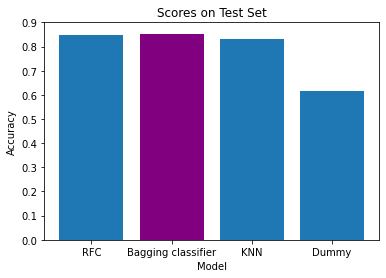

In [112]:
#plot of accuracy scores for different models
fig, ax = plt.subplots()

model_names = list(model_scores.keys())
model_names.append('Dummy')

test_scores = list(model_scores.values())
test_scores.append(dummy_clf.score(X_test, y_test))

colors = ['purple' if name=='Bagging classifier' else 'tab:blue' for name in model_names]
ax.bar(model_names, test_scores, color=colors);

ax.set_ylim([0, 0.9])
ax.set_title('Scores on Test Set')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy');

plt.savefig('test_accuracy_scores.png', dpi=300)

Based on accuracy score alone, the Bagging classifier was our strongest performing model. The test scores for all three models were relatively close. Bagging classifier was at the top with 85.0% accuracy, the Random Forest classifier had 84.8% accuracy, and the K-Nearest Neighbors classifier had 83.2% accuracy.

## Other Metrics

While model accuracy is important, other metrics such as precision and recall are important in evaluating model performance with specific regard to model sensitivity to different pump functionalities.

Our goal with these models is to identify non-functional pumps so that organizations can perform repair or replacement. Therefore we've defined 'non functional' as the "positive" case for these precision and recall scores. Recall was the more important metric. In this scenario, recall measures how many non-functional pumps our models are able to detect out of all the non-functional pumps in the dataset. 'False negatives' (i.e. classified 'functional' when it is actually 'non functional') represent a greater risk to water access as pumps that are in need of attention could get overlooked if misclassified by the model. 


We used sci-kit learn's plot_confusion_matrix to visualize our models' predictions against the actual classifications in y-test. Additionally, the precision and recall scores for each model were calculated. Note that the positive label in precision and recall has been set to 'non functional'.

In [99]:
#get predicted values for metric scores
rfc_preds = first_rfc_pipe.predict(X_test)
rfc_preds

array(['non functional', 'functional', 'functional', ..., 'functional',
       'functional', 'functional'], dtype=object)

In [81]:
#get predicted values for metric scores
bagging_preds = bag_dt_pipe.predict(X_test)

In [79]:
#get predicted values for metric scores
knn_preds = knn_model_pipe.predict(X_test)

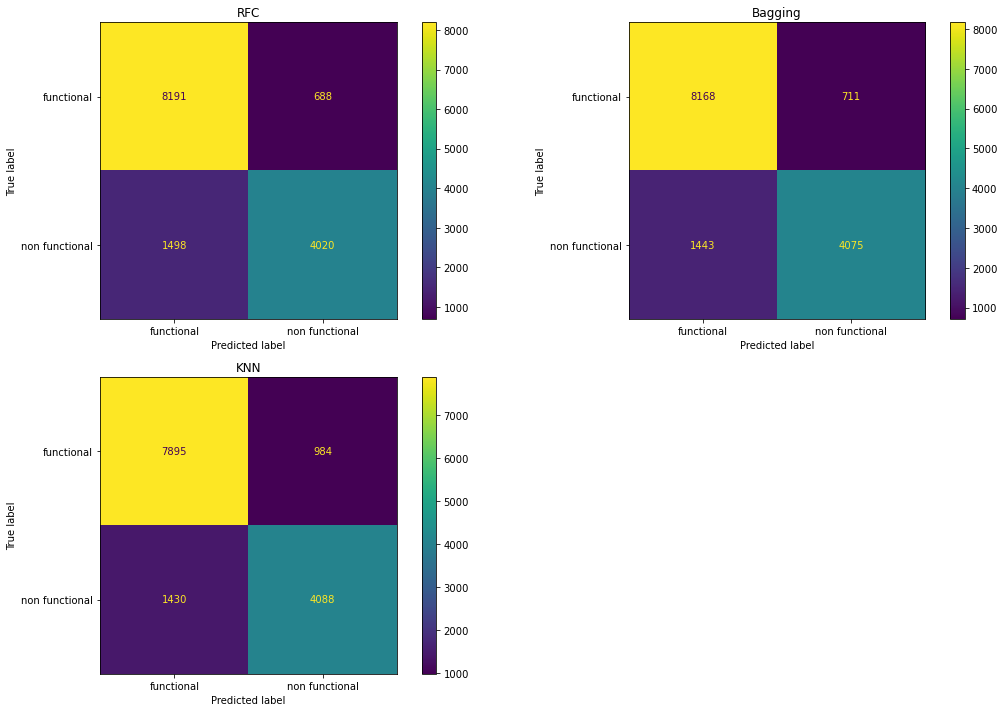

In [102]:
#plot confusion matrices for all 3 models
fig, ax = plt.subplots(2, 2, figsize=(15,10))

ax[0, 0].set_title("RFC")
ax[0, 1].set_title("Bagging")
ax[1, 0].set_title("KNN")
ax[1, 1].remove()

classifiers = [first_rfc_pipe, bag_dt_pipe, knn_model_pipe]

for cls, ax in zip(classifiers, ax.flatten()):
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax)

plt.tight_layout();

plt.savefig('confusion_matrices.png', dpi=300)

In [103]:
rfc_precision = precision_score(y_test, rfc_preds, pos_label="non functional")
rfc_recall = recall_score(y_test, rfc_preds, pos_label="non functional")
rfc_precision, rfc_recall

(0.8538657604078165, 0.7285248278361726)

In [105]:
bagging_precision = precision_score(y_test, bagging_preds, pos_label="non functional")
bagging_recall = recall_score(y_test, bagging_preds, pos_label="non functional")
bagging_precision, bagging_recall

(0.8514417049728374, 0.7384922073214933)

In [106]:
knn_precision = precision_score(y_test, knn_preds, pos_label="non functional")
knn_recall = recall_score(y_test, knn_preds, pos_label="non functional")
knn_precision, knn_recall

(0.805993690851735, 0.74084813338166)

In [113]:
#print out all precision scores
print(f'Precision score RFC: {rfc_precision}')
print(f'Precision score Bagging: {bagging_precision}')
print(f'Precision score KNN: {knn_precision}')

Precision score RFC: 0.8538657604078165
Precision score Bagging: 0.8514417049728374
Precision score KNN: 0.805993690851735


In [114]:
#print out all recall scores
print(f'Recall score RFC: {rfc_recall}')
print(f'Recall score Bagging: {bagging_recall}')
print(f'Recall score KNN: {knn_recall}')

Recall score RFC: 0.7285248278361726
Recall score Bagging: 0.7384922073214933
Recall score KNN: 0.74084813338166


Out of our three models, the KNN model has the highest recall score for the 'non functional' category at 0.741. This means that for the test data, it correctly classified 74.1% of non-functional pumps out of all true non-functional pumps in the dataset.The other two models have recall scores within 1-2%: Bagging had a recall score of 0.738 and Random Forest had a recall score of 0.726.

Precision scores for our models were higher than the recall scores. KNN underperformed in precision, lagging behind the other two models at 0.806. Bagging and RandomForest had precision scores around 0.85.

In choosing a best model, we wanted to take both accuracy and recall into account. Overall, Bagging is our best model with an accuracy score of 0.850 and a recall score of 0.738. The low recall score is a feature we'd like to address if we continued to improve on this model in the future. Given that the precision score for these models is higher than the recall scores, there is room for a tradeoff between recall and precision. Increasing sensitivity to non-functional pumps would improve recall and reduce the number of 'false negatives'. 

One possible way to do this is to adjust the probability threshold for determining a non-functional class to tune the model's sensitivity to the 'non functional' class. This would cause models to favor the non-functional class, driving up the sensitivity to non-functional pumps. While this comes at a cost of correctly detecting functional pumps, the health benefits of identiying and fixing non-functional pumps is a strong reason to justify this tradeoff. A precision vs recall curve could be used to determine an ideal threshold to balance the tradeoff.

In [20]:
#bag_dt_pipe.predict_proba(X_test)

# Conclusion

After iterating over several models and model types, we developed a Bagging classifier to determine a water pump's functionality based on regional information, management and installation information, water quality and amount, and pump characteristics.

Our best performing model is a BaggingClassifier with DecisionTreeClassifiers as the base estimator. This model had an accuracy score of 0.850, meaning it correctly classified a pump's functional status 85% of the time. Our best model was limited in its sensitivity towards the non-functional class. While it correctly classified 73.8% of all non-functional cases, the model still has room for improvement. Improving the model's recall for non-functional water pumps would improve its efficacy in identifying places where people lack access to clean water. The top feature importances for the model were all related to 'installer', the organization/individual responsible for installing the water pump. This indicates that 'installer' has some implications in predicting a pump's functionality and highlights pump installation as a possible area for organizations to investigate.

This model is a tool for organizations seeking to improve water access in Tanzania. Due to the limited data available on the age of each water pump, our model could be used when age data is not readily available and look at other features in order to classify pump funtionality. Both government agencies and non-governmental organizations could use the model to where pumps are non-functional and provide aid to people who are unable to access safe sources of water. 
 

### Further steps

Here are some areas for further investigation to produce an improved model:

- Improve sensitivity to non-functional pumps: People around non-functional pumps lack access to clean water. Correctly identifying cases of non-functional pumps is critical to improving water access for Tanzanians.


- Reduce model complexity: We highlighted age as a feature where information is lacking. The model currently takes in 17 features. Given the challenge of collecting information to feed into the model, a model that can make predictions when less infomation is available could be more useful for organizations to utilize. The challenge is to balance model performance with reduced complexity/information availability.

- Identify trends associated with installer: Our best model pulls out 'installer' features as having the highest feature importances. There could be some interactions between who is installing the pump and functionality. More investigation into this relationship could reveal useful insights for NGOs and government agencies to improve water pump installation. 